In [1]:
from alpha_vantage.timeseries import TimeSeries

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from scipy.stats import shapiro, jarque_bera
from statsmodels.tsa.stattools import adfuller

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

from tqdm import tqdm
import pickle
look_back = 5

In [ ]:
# Original code from: https://colab.research.google.com/drive/18WiSw1K0BW3jOKO56vxn11Fo9IyOuRjh#scrollTo=2SoQJk5BYOas

## Data

In [2]:
data = pd.read_csv('NVDA.csv')
data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)

In [3]:
# preprocessing the data
data

,Date,Close,Volume
0,2019-03-29,44.889999,45689600
1,2019-04-01,45.570000,48382400
2,2019-04-02,45.750000,44092000
3,2019-04-03,47.154999,78350400
4,2019-04-04,47.064999,45737600
...,...,...,...
1254,2024-03-22,942.890015,58521500
1255,2024-03-25,950.020020,55213600
1256,2024-03-26,925.609985,51364800
1257,2024-03-27,902.500000,58606700


In [18]:
# split the data into train, validation and test sets
def split_data(data: pd.DataFrame, train_size: float = 0.6, val_size: float = 0.2):
    train_size = round(data.shape[0] * train_size)
    val_size = round(data.shape[0] * val_size)
    test_size = data.shape[0] - train_size - val_size
    
    train = data.iloc[:train_size]
    val = data.iloc[train_size:train_size+val_size]
    test = data.iloc[train_size+val_size:]
    
    train.loc[:, 'Date'] = pd.to_datetime(train['Date'])
    val.loc[:, 'Date'] = pd.to_datetime(val['Date'])
    test.loc[:, 'Date'] = pd.to_datetime(test['Date'])
    return train, val, test

train, val, test = split_data(data, train_size=0.6, val_size=0.2)

In [19]:
len(train), len(val), len(test)

(755, 252, 252)

In [24]:
755 / 1007

0.7497517378351539

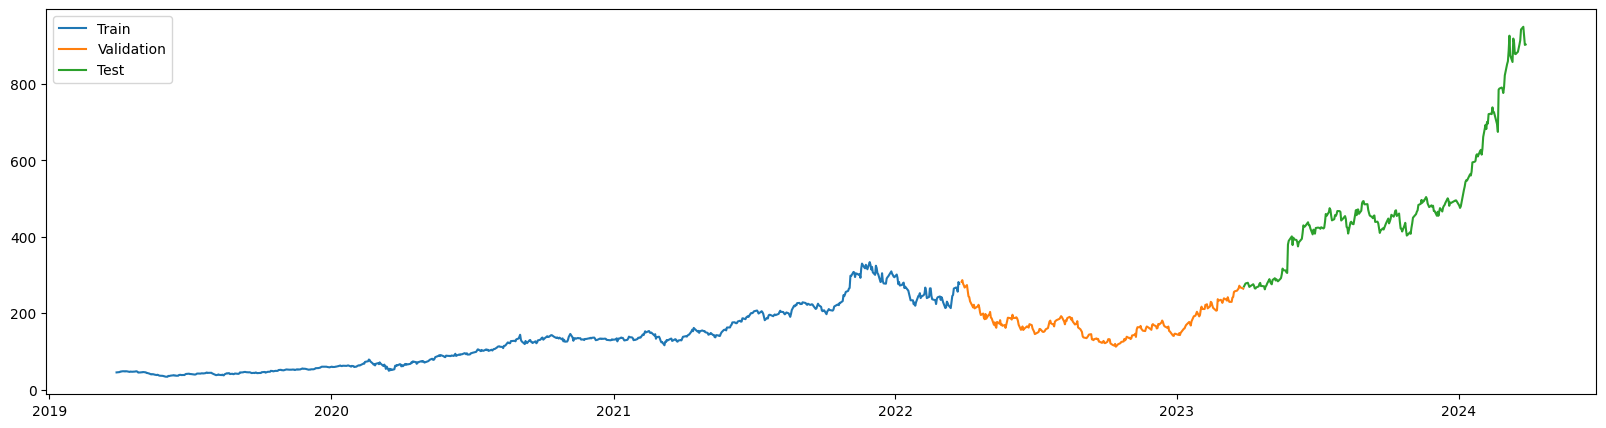

In [6]:
def plot_data_split(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame):
    plt.figure(figsize=(20, 5))
    plt.plot(train["Date"], train['Close'], label='Train')
    plt.plot(val["Date"],val['Close'], label='Validation')
    plt.plot(test["Date"], test['Close'], label='Test')
    plt.legend()
    plt.show()
    
plot_data_split(train, val, test)

In [7]:
def data_prepation_training(data: pd.DataFrame):
    sc = MinMaxScaler(feature_range=(0,1))
    data_scaled_close = train['Close'].values.reshape(-1, 1)
    data_scaled_close = sc.fit_transform(data_scaled_close)
    data_scaled = pd.DataFrame(data_scaled_close, columns=['Close'])
    data_scaled.index = train['Date']
    return data_scaled, sc

# we are trying to predict the close price of the stock from the past n days of close price
def format_dataset(data_scaled,look_back=60):
    X_train = []
    X_train_date = []
    y_train = []
    y_train_date = []
    for i in range(look_back, len(data_scaled)):
        # get the past 'look_back' days of close price
        X_train.append(data_scaled.iloc[i-look_back:i, 0])
        X_train_date.append(data_scaled.index[i-look_back:i])
        y_train.append(data_scaled.iloc[i, 0])
        y_train_date.append(data_scaled.index[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train_date, y_train_date = np.array(X_train_date), np.array(y_train_date)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_train_date = np.reshape(X_train_date, (X_train_date.shape[0], X_train_date.shape[1], 1))
    return X_train, y_train, X_train_date, y_train_date

In [8]:
def testing_validation(train, val, look_back=60):
    sc = MinMaxScaler(feature_range=(0,1))
    total_dataset = pd.concat((train['Close'], val['Close']), axis=0)
    total_datset_date = pd.concat((train['Date'], val['Date']), axis=0)
    inputs = total_dataset[len(total_dataset) - len(val) - look_back:].values
    inputs_date = total_datset_date[len(total_datset_date) - len(val) - look_back:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.fit_transform(inputs)
    X_val = []
    X_val_date = []
    for i in range(look_back, len(inputs)):
        X_val.append(inputs[i-look_back:i, 0])
        X_val_date.append(inputs_date[i-look_back:i])
    X_val = np.array(X_val)
    X_val_date = np.array(X_val_date)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_val_date = np.reshape(X_val_date, (X_val_date.shape[0], X_val_date.shape[1], 1))
    return X_val, X_val_date, sc

In [9]:
def prepare_data(data: pd.DataFrame, look_back=60):
    data_scaled, sc = data_prepation_training(data)
    X, y, X_date, y_date = format_dataset(data_scaled, look_back=look_back)
    return X, y, X_date, y_date

In [10]:
X_train, y_train, X_train_date, y_train_date = prepare_data(train, look_back=look_back)

/Users/vincentzhao/anaconda3/envs/deep_learning_finance/lib/python3.11/site-packages/pandas/core/indexes/base.py:7630: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


In [11]:
train_and_val = pd.concat((train, val), axis=0)
X_val, X_val_date, sc_val = testing_validation(train, val, look_back=look_back)
X_test, X_test_date, sc_test = testing_validation(train, test, look_back=look_back)

In [12]:
val_close = val['Close'].values
test_close = test['Close'].values
train_close = train['Close'].values

In [13]:
val_close = np.array(object=val_close)
test_close = np.array(object=test_close)
train_close = np.array(object=train_close)

In [14]:
# save the data
np.save("./Train/train_close.npy", train_close)

np.save('./Train/X_train.npy', X_train)
np.save('./Train/y_train.npy', y_train)
np.save('./TrainX_train_date.npy', X_train_date)
np.save('./Train/y_train_date.npy', y_train_date)

np.save('./Validation/X_val.npy', X_val)
np.save('./Validation/val.npy', val_close)

np.save('./Test/X_test.npy', X_test)
np.save('./Test/test_close.npy', test_close)

# save pickle file
with open('./Scaler/scaler_val.pkl', 'wb') as f:
    pickle.dump(sc_val, f)

# save pickle file
with open('./Scaler/scaler_test.pkl', 'wb') as f:
    pickle.dump(sc_test, f)